In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from utils.prepare_dataset import prepare_dataset_fixedsize

/home/dingkang/envs/nlp_a4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_GPU = True if torch.cuda.is_available() else "cpu"

In [3]:
max_seq_len = 64
batch_size = 64


geom_train, geom_val, label_train, label_val, gs = prepare_dataset_fixedsize(dataset_size=2000)

train_tokens = torch.tensor(geom_train, dtype=torch.float32)
val_tokens = torch.tensor(geom_val, dtype=torch.float32)
train_labels= torch.tensor(label_train, dtype=torch.long)
val_labels = torch.tensor(label_val, dtype=torch.long)

train_loader = DataLoader(TensorDataset(train_tokens, train_labels), batch_size=batch_size, shuffle=True)

In [4]:
class ConvAE(nn.Module):
    def __init__(self, fea_dim):
        super().__init__()
        self.encoder = nn.Sequential(nn.Conv1d(fea_dim, 64, kernel_size=5, padding=2),
                                     nn.ReLU(),
                                     nn.Conv1d(64, 32, kernel_size=5, padding=2))
        
        self.decoder = nn.Sequential(nn.ConvTranspose1d(32, 64, kernel_size=5, padding=2),
                                     nn.ReLU(),
                                     nn.ConvTranspose1d(64, fea_dim, kernel_size=5, padding=2))
        # self.relu = nn.ReLU()

        self.mse_loss_func = nn.MSELoss()
        self.meta_loss_func = nn.CrossEntropyLoss()
        
    def forward(self, x):

        permuated_x = x.permute(0, 2, 1)  # Permute to (batch_size, channels, seq_len)
        encoded = self.encoder(permuated_x)
        decoded = self.decoder(encoded)

        decoded = decoded.permute(0, 2, 1)

        coord_output = decoded[:, :, :2]
        meta_output = decoded[:, :, 2:]
        target_meta = torch.argmax(x[:, :, 2:], dim=-1)
        coord_loss = self.mse_loss_func(coord_output, x[:, :, :2])
        # 3 is meta one-hot vocab size
        meta_loss = self.meta_loss_func(meta_output.contiguous().view(-1, 3), target_meta.contiguous().view(-1))

        meta_indices = torch.argmax(meta_output, dim=-1)
        output = torch.cat([coord_output, nn.functional.one_hot(meta_indices, 3)], dim=-1)

        return output, coord_loss*0.25 + meta_loss*0.75
    
    def get_hidden(self, x):
        encoded = self.encoder(x.permute(0, 2, 1))
        encoded = encoded.view(x.size(0), -1)
        return encoded

In [14]:
autoencoder = ConvAE(5)
optimizer = optim.Adam(autoencoder.parameters(), lr=0.004)

num_epoch = 30

for epoch in range(num_epoch):
    autoencoder.train()
    total_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs, loss = autoencoder(inputs)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    train_loss = total_loss/len(train_loader)

    autoencoder.eval()
    with torch.no_grad():
        val_outputs, loss = autoencoder(val_tokens)
        val_loss = loss.item()
    
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")

Epoch 1, Train Loss: 0.11398448757827281, Val Loss: 0.014409962110221386
Epoch 2, Train Loss: 0.009079623762518167, Val Loss: 0.006302011199295521
Epoch 3, Train Loss: 0.0050942182773724195, Val Loss: 0.003568114712834358
Epoch 4, Train Loss: 0.004381349976174533, Val Loss: 0.002960619982331991
Epoch 5, Train Loss: 0.0026705873664468528, Val Loss: 0.002196737565100193
Epoch 6, Train Loss: 0.0017107805400155484, Val Loss: 0.0013556508347392082
Epoch 7, Train Loss: 0.0011105502746067942, Val Loss: 0.0009941537864506245
Epoch 8, Train Loss: 0.0008203188690822571, Val Loss: 0.0007794848061166704
Epoch 9, Train Loss: 0.0011438339704182, Val Loss: 0.0035045831464231014
Epoch 10, Train Loss: 0.000923927974072285, Val Loss: 0.0005597986746579409
Epoch 11, Train Loss: 0.00042996090196538715, Val Loss: 0.00047820029431022704
Epoch 12, Train Loss: 0.00032068261847598476, Val Loss: 0.0004000801418442279
Epoch 13, Train Loss: 0.00026653661538148296, Val Loss: 0.0003581155906431377
Epoch 14, Train L

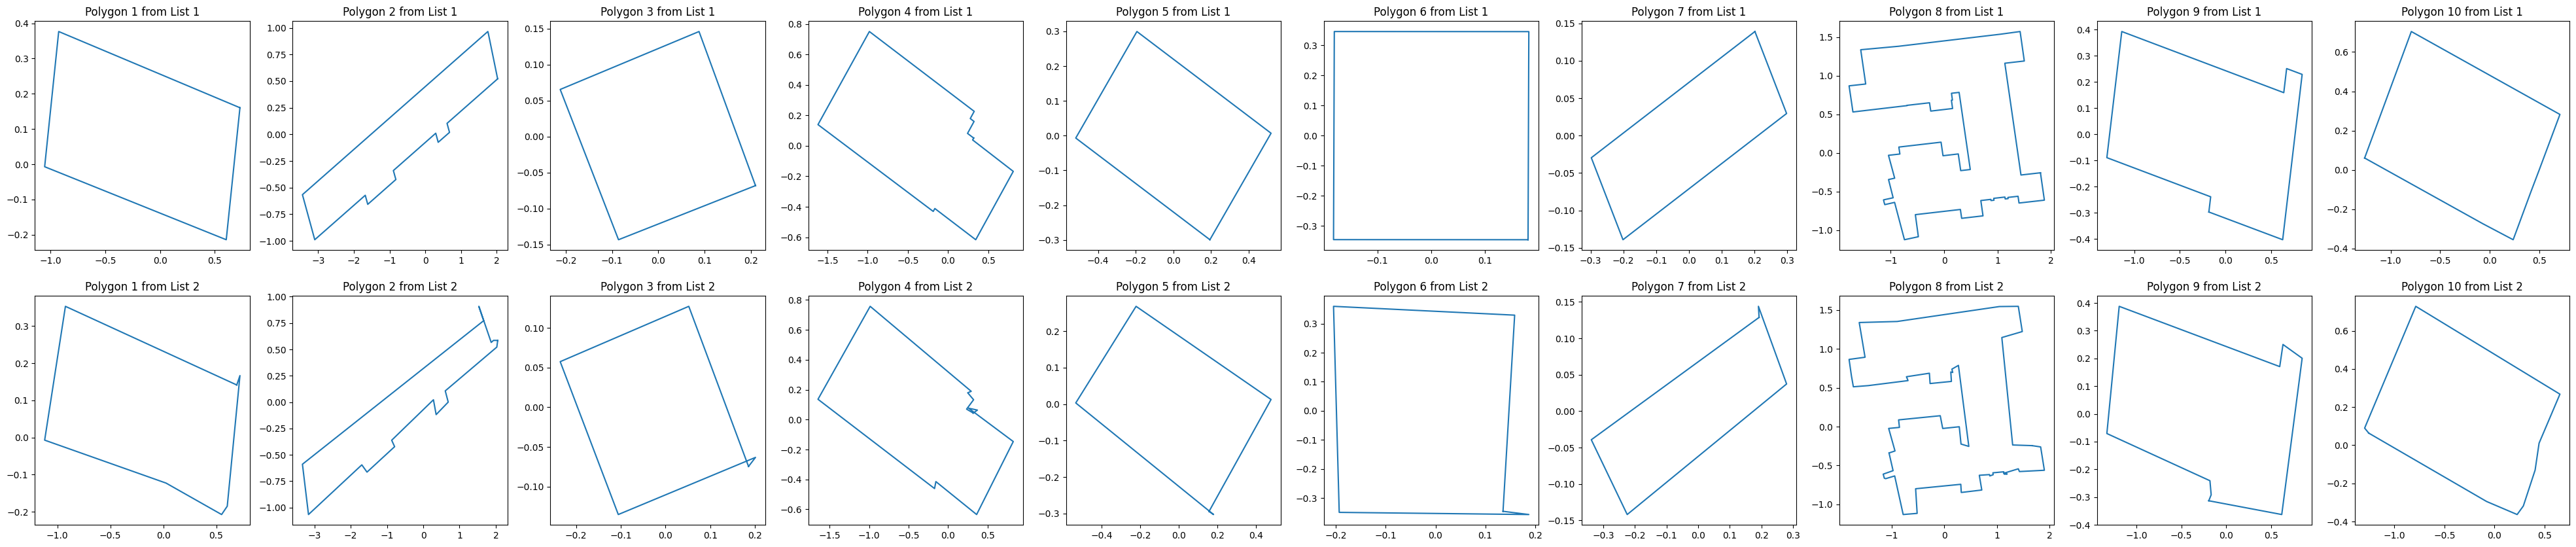

In [13]:
from utils.vector2shape import reverse_vector_polygon
import matplotlib.pyplot as plt

num_samples = 10
ori_polygons = [reverse_vector_polygon(token) for token in val_tokens[:num_samples]]
new_polygons = [reverse_vector_polygon(token) for token in val_outputs[:num_samples]]

# Create a figure with subplots for each polygon
fig, axs = plt.subplots(2, num_samples, figsize=(5*num_samples, 10))

# Plot polygons from the first list
for i, polygon in enumerate(ori_polygons):
    axs[0, i].set_title('Polygon {} from List 1'.format(i+1))
    x, y = polygon.exterior.xy
    axs[0, i].plot(x, y)

# Plot polygons from the second list
for i, polygon in enumerate(new_polygons):
    axs[1, i].set_title('Polygon {} from List 2'.format(i+1))
    x, y = polygon.exterior.xy
    axs[1, i].plot(x, y)

# Show the plot
plt.show()


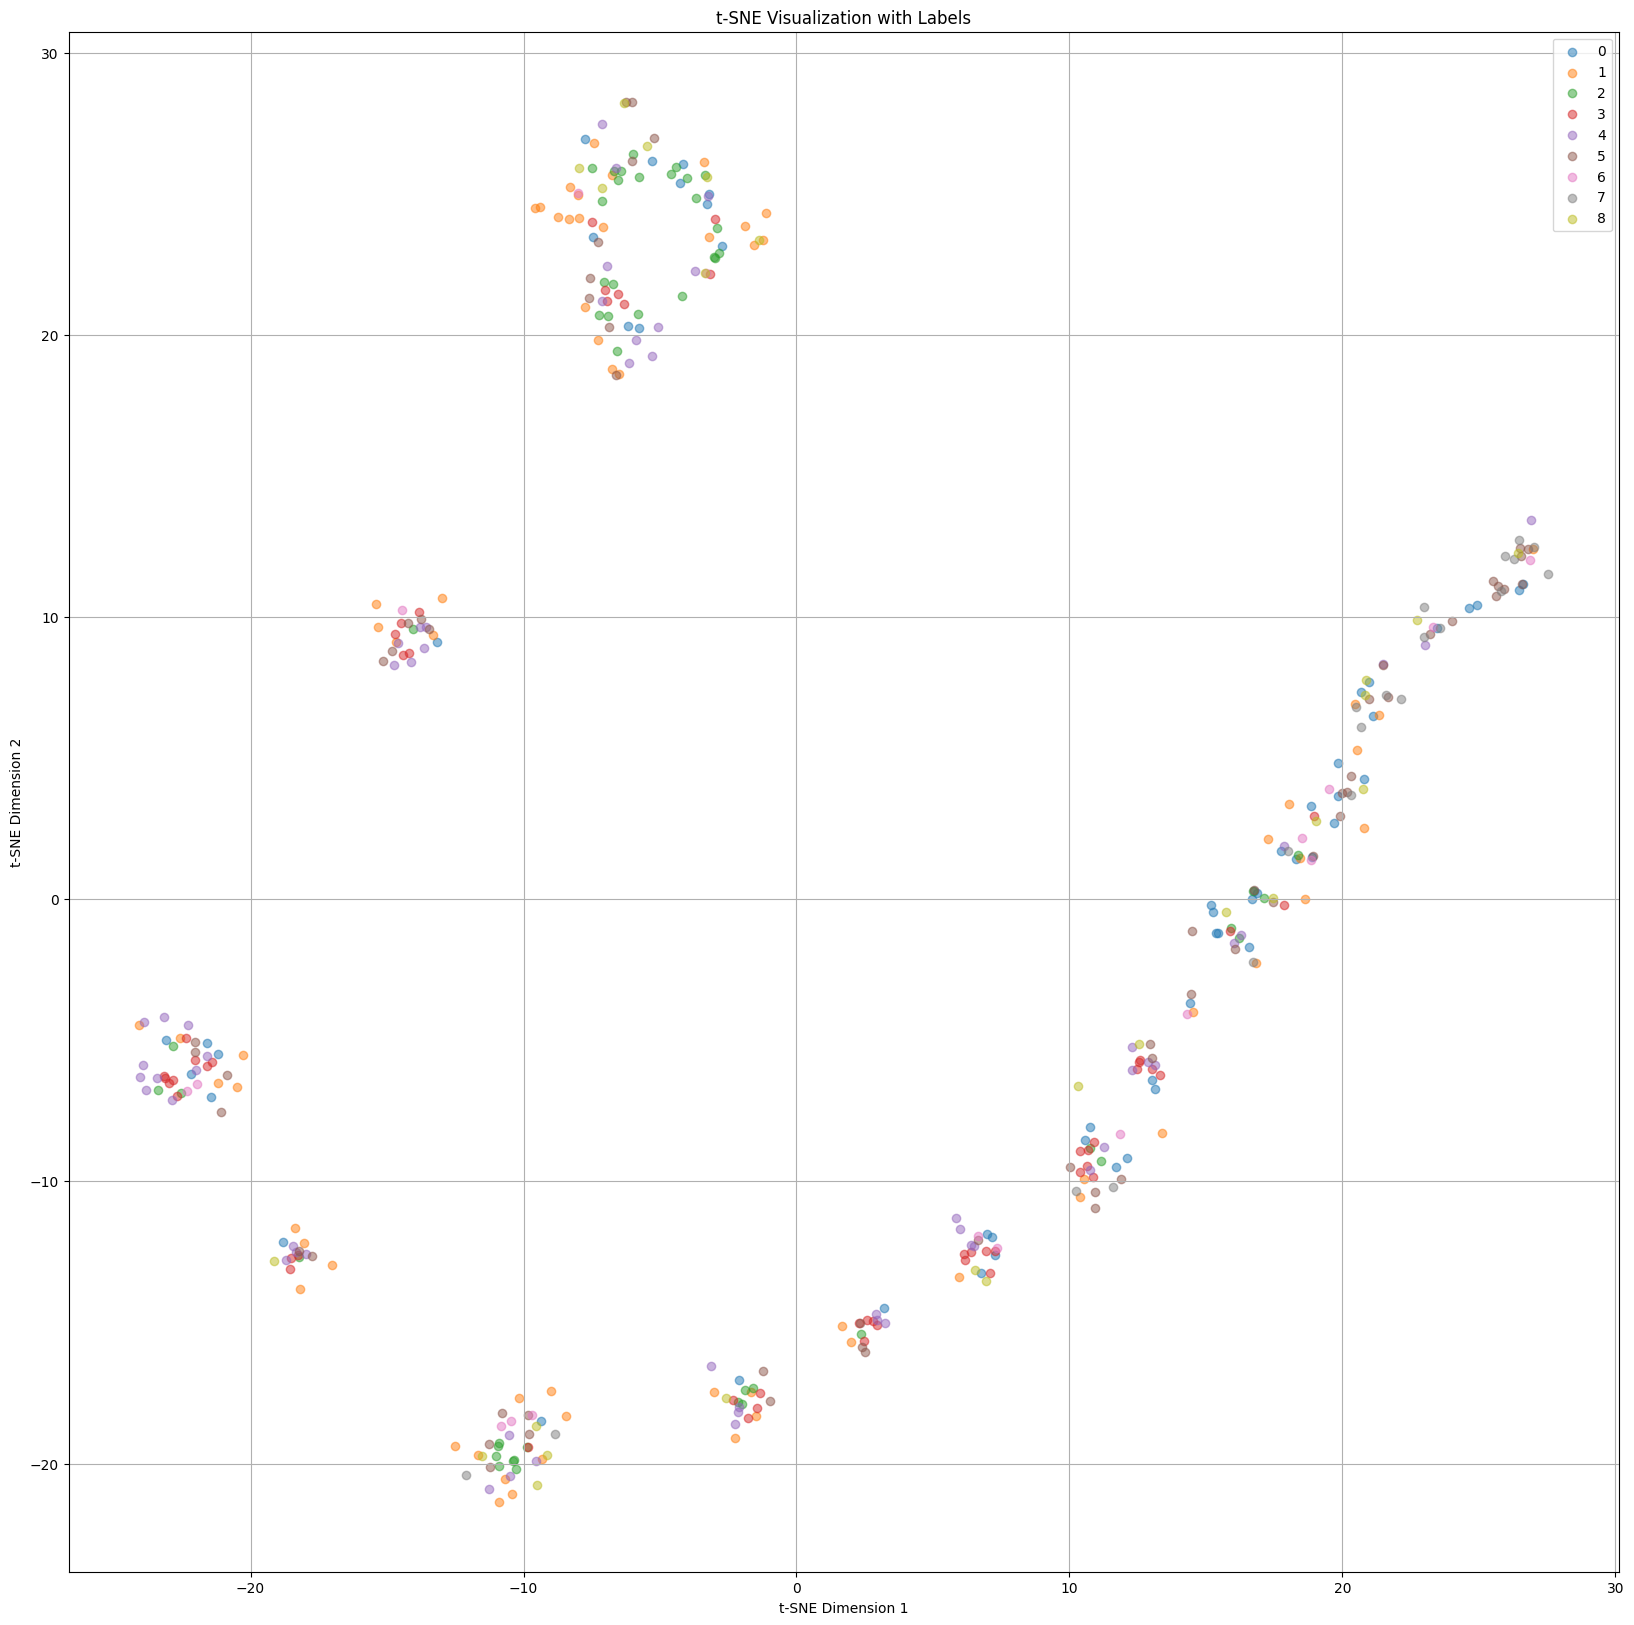

In [34]:
autoencoder.eval()
with torch.no_grad():
    hidden = autoencoder.get_hidden(val_tokens)
    hidden = hidden.detach().numpy()

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np


tsne = TSNE(n_components=2, random_state=0)
projections = tsne.fit_transform(hidden)

plt.figure(figsize=(20, 20))

# Plot each class separately
for label in np.unique(val_labels):
    indices = val_labels == label
    plt.scatter(projections[indices, 0], projections[indices, 1], label=label, alpha=0.5)

plt.title('t-SNE Visualization with Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

In [55]:
# autoencoder.eval()
# with torch.no_grad():
#     train_hidden = autoencoder.get_hidden(train_tokens)
#     val_hidden = autoencoder.get_hidden(val_tokens)

# Without encoding
train_hidden = train_tokens.view(train_tokens.size(0), -1)
val_hidden = val_tokens.view(val_tokens.size(0), -1)

train_loader = DataLoader(TensorDataset(train_hidden, train_labels), batch_size=batch_size, shuffle=True)

In [56]:
# Define the classifier
class Classifier(nn.Module):
    def __init__(self, input_size, dense_size, num_classes, dropout):
        super().__init__()
        self.dense1 = nn.Linear(input_size, dense_size)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(dense_size, num_classes)

    def forward(self, x):
        x = self.relu(self.dense1(x))
        x = self.dropout(x)
        x = self.dense2(x)
        # # Linear probing
        # x = self.dense1(x)
        return x
    
classifier = Classifier(train_hidden.size(1), 128, 9, 0.0)

if USE_GPU:
    classifier = classifier.to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(classifier.parameters(), lr=0.004)
optimizer = optim.Adam(classifier.parameters(), lr=0.004, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001)

num_epochs = 100

def train(model, loader):
    model.eval()
    train_loss = 0.0
    correct = 0
    total = 0
    for batch_x, batch_y in loader:
        if USE_GPU:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, dim=-1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
    train_loss /= len(loader)
    train_acc = correct / total
    return train_loss, train_acc

def evaluate(model, tokens, labels):
    model.eval()
    with torch.no_grad():
        if USE_GPU:
            tokens, labels = tokens.to(device), labels.to(device)
        outputs = model(tokens)
        eval_loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, dim=-1)
        eval_acc = (predicted == labels).sum().item() / labels.size(0)
    return eval_loss, eval_acc

for epoch in range(num_epochs):
    train_loss, train_acc = train(classifier, train_loader)
    val_loss, val_acc = evaluate(classifier, val_hidden, val_labels)
    print(f"Epoch: {epoch+1}, Train Loss: {train_loss}, Train Acc {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}")


# # Test
# test_loss, test_acc = evaluate(classifier, test_loader)
# print(f"Test Loss: {test_loss}, Test Acc: {test_acc}")

Epoch: 1, Train Loss: 2.063205919265747, Train Acc 0.198125, Val Loss: 2.032545804977417, Val Acc: 0.1925
Epoch: 2, Train Loss: 1.990687313079834, Train Acc 0.206875, Val Loss: 2.0493991374969482, Val Acc: 0.22
Epoch: 3, Train Loss: 1.9681332588195801, Train Acc 0.22375, Val Loss: 2.043238878250122, Val Acc: 0.185
Epoch: 4, Train Loss: 1.9338637256622315, Train Acc 0.24375, Val Loss: 2.0500686168670654, Val Acc: 0.1975
Epoch: 5, Train Loss: 1.915404772758484, Train Acc 0.25375, Val Loss: 2.0321145057678223, Val Acc: 0.2025
Epoch: 6, Train Loss: 1.8809131145477296, Train Acc 0.27875, Val Loss: 2.0432016849517822, Val Acc: 0.22
Epoch: 7, Train Loss: 1.8465873956680299, Train Acc 0.289375, Val Loss: 1.9923993349075317, Val Acc: 0.26
Epoch: 8, Train Loss: 1.797690658569336, Train Acc 0.33125, Val Loss: 2.0217065811157227, Val Acc: 0.2475
Epoch: 9, Train Loss: 1.7684524965286255, Train Acc 0.33625, Val Loss: 2.0122625827789307, Val Acc: 0.2475
Epoch: 10, Train Loss: 1.7343643999099732, Trai

In [60]:
labels_array = val_labels.numpy()
length = labels_array.shape[0]
# Find unique classes and their frequencies
unique_classes, class_counts = np.unique(labels_array, return_counts=True)
fre_dict = {c: count/length for c, count in zip(unique_classes, class_counts)}
fre_dict

{0: 0.1375,
 1: 0.16,
 2: 0.12,
 3: 0.135,
 4: 0.1425,
 5: 0.15,
 6: 0.0425,
 7: 0.05,
 8: 0.0625}